In [2]:
%%capture
import sys
import math
import random
import pickle
import matplotlib
import pandas as pd
import numpy as np
#import datetime
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import regex as re
#from numpy import *
from scipy import stats
from scipy.stats import ttest_1samp
from datetime import timedelta, datetime, time, date
from statsmodels.regression.linear_model import RegressionResults
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import rc
from tqdm.notebook import tqdm
from cycler import cycler
tqdm().pandas()

color_list = ["#348ABD","#A60628","#7A68A6","#467821","#CF4457","#188487","#E24A33"]
style = {
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": True,
  "axes.prop_cycle": cycler('color', color_list),
  "axes.facecolor": "#ffffff",
  "axes.labelsize": "large",
  "axes.grid": True,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "svg.fonttype": "path"}

matplotlib.rcParams.update(style)

# Modify pandas display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

data_path       = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Python/Data/"
path_data_files = '/Users/Stefa/Documents/Sentiment Analysis Files/'

extended_model_path = data_path+'Classification/DagoBERT/SCE_Loss_minw_25_lr_5e5_3ep_bs32_wd_1e2_a0_5_b3_NN1_w2v_topics/' 
extended_data_path  = path_data_files+'filtered_news_data_for_transformer/train_validation_data' #data_with_922_constituents/train_validation_data/'

output_path = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/"

def load_data(file):
    df = pd.read_csv(file, encoding='utf-8-sig')
    df.Date = pd.to_datetime(df.Date)
    df = df.set_index(['Ticker', 'Date'])
    df = df.rename(columns={'Prediction value': 'prediction_value'})
    return df


## Filter for topics
def filter_topic(data, topic):
    print('Topic:', topic)
    return data[data[topic] > 0] 


def t_test(sample, parent):
    mu = np.mean(parent)
    t_value = (np.mean(sample)-mu)/(np.std(sample)/np.sqrt(sample.shape[0]))
    return t_value  



def cal_metric(case, metric='mean', setting='Conditional_1'):
    if setting == 'neg_sentiment':
        label = 'Negative sentiment'
    elif setting == 'pos_sentiment':
        label = 'Positive sentiment'
    else:
        label = re.sub(r'_', ' ', setting)
    var = table[setting].loc[(metric, case)]*100
        
    return var, label



def plot_results(table, cases=['Case_1_2', 'Case_3_4'], idiosyncratic=False, show_standard_error=True, yscale=0.75):   
    """
    display_style: 'standard' or 'sentiment'
    """
    axes  = {}
    fig, (axes[0], axes[1]) = plt.subplots(1,2,figsize=(24,8))
    
    for i, case in enumerate(cases):
        if case == None:
            continue
        if idiosyncratic:
            title = f'Idiosyncratic mean returns ({case})'
        else: 
            title = f'Mean returns ({case})'

        mean_0       = table['Unconditional'].loc[('mean', case)]*100
        std_error_0  = table['Unconditional'].loc[('std_error', case)]*100

        mean_1, label_1 = cal_metric(case, metric='mean',      setting='neg_sentiment')
        mean_2, label_2 = cal_metric(case, metric='mean',      setting='pos_sentiment')               
        std_error_1, _  = cal_metric(case, metric='std_error', setting='neg_sentiment')
        std_error_2, _  = cal_metric(case, metric='std_error', setting='pos_sentiment')

        above_line_0 = (mean_0.values+std_error_0.values).astype(np.float32)
        below_line_0 = (mean_0.values-std_error_0.values).astype(np.float32)
        above_line_1 = (mean_1.values+std_error_1.values).astype(np.float32)
        below_line_1 = (mean_1.values-std_error_1.values).astype(np.float32)
        above_line_2 = (mean_2.values+std_error_2.values).astype(np.float32)
        below_line_2 = (mean_2.values-std_error_2.values).astype(np.float32)

        
        axes[i].plot(mean_1, label=label_1)
        axes[i].plot(mean_2, label=label_2)
        axes[i].plot(mean_0, label='Unconditional')
        if show_standard_error:
            axes[i].fill_between(mean_1.index, above_line_1, below_line_1, color='b', alpha=.1) 
            axes[i].fill_between(mean_2.index, above_line_2, below_line_2, color='r', alpha=.1) 
            axes[i].fill_between(mean_0.index, above_line_0, below_line_0, color='k', alpha=.1) 

        axes[i].set_title(title)
        axes[i].set_xlabel('z-score')
        axes[i].set_ylabel('Avg. daily return')
        axes[i].set_ylim([-yscale,yscale])
        axes[i].legend()
    plt.show()    
    

# Filer for Industries
constituents = pd.read_csv(data_path+'label_counts.csv')
sectors = constituents.ICBIN.unique()

confidence_levels = {0.9:1.645, 0.95:1.96, 0.96:2.05, 0.98:2.33, 0.99:2.58}

In [ ]:
r_cols = ['return_t_V', 'return_t_IV', 'return_t_III', 'return_t_II', 'return_t_I', 
                     'return_t', 'return_t_1', 'return_t_2', 'return_t_3', 'return_t_4', 
                     'return_t_5', 'return_t_6', 'return_t_7', 'return_t_8']

z_cols = ['z_value_t_III', 'z_value_t_II', 'z_value_t_I', 'z_value_t', 'z_value_t_1']


class construct_df():
    def __init__(self, 
                 trade_time = 'MOO', 
                 abnormal_returns   = False, 
                 return_period      = 'mo_to_mo', 
                 idiosync_z_scores  = False, 
                 z_val_interval_moc = 'z_values_moc_127d_rw', 
                 z_val_interval_moo = '',
                 freshness  = None,
                 sel_topics = []):
        
        """
        trade_time:
        MOO ... market order open
        MOC ... market order close
        """
        abn = '_abn' if abnormal_returns else '' 
        idiosync  = '_idiosync' if idiosync_z_scores else ''
               
        col0 = ['Timestamp_ET', 'Ticker', 'Date', 'prediction_value', 'freshness', 'topic_1', 'topic_2', 'topic_3', 'topic_4']
        col1 = ['Timestamp_ET', 'Ticker', 'Date', 'prediction_value', 'z_value_t', 'freshness', 'topic_1', 'topic_2', 'topic_3', 'topic_4']+ r_cols
                  
        file1 = f'train_valid_data_pred_and{abn}_returns_mc_to_mc_6_5h_z_val{idiosync}_fresh_2002-2021.csv'
        file2 = f'train_valid_data_pred_and{abn}_returns_{return_period}_17_5h_z_val{idiosync}{z_val_interval_moo}_fresh_2002-2021_v2.csv'
        file3 = z_val_interval_moc+idiosync+'.csv'
        print(f'Load {file1}')
        print(f'Load {file2}')
        print(f'Load {file3}')
        df_mo_to_mc = self.load_data(extended_model_path+file1)       # market open to maket close
        df_mc_to_mo = self.load_data(extended_model_path+file2)       # market close to maket open            

        # Load additional z-values (file reference: Stock Return Calculation.ipynb)
        z_values_moc = pd.read_csv(data_path+file3, encoding='utf-8')      
        z_values_moc.Date = pd.to_datetime(z_values_moc.Date)                                   
        z_values_moc = z_values_moc.set_index('Date')
        self.z_values_moc_t_I = z_values_moc.shift(1)

        if trade_time == 'MOO':    
            df_mo_to_mc = df_mo_to_mc[col0]
            df_mc_to_mo = df_mc_to_mo[col1]

            # Add z-value of market close on day t-1
            df_mc_to_mo.insert(3, 'z_value_t_I', np.nan)
            df_mc_to_mo['z_value_t_I'] = df_mc_to_mo.apply(self.get_z_val, axis=1)

        elif trade_time == 'MOC':
            df_mo_to_mc = df_mo_to_mc[col1]
            df_mc_to_mo = df_mc_to_mo[col0]   

        df_mo_to_mc['period'] = 'mo_to_mc'
        df_mc_to_mo['period'] = 'mc_to_mo'

        self.df = pd.concat([df_mo_to_mc, df_mc_to_mo], join='outer', axis=0)
        self.df = self.df.sort_values(by='Timestamp_ET').reset_index(drop=True)
        self.df.Date = pd.to_datetime(self.df.Date)
        self.df.Timestamp_ET = pd.to_datetime(self.df.Timestamp_ET)
        self.df = self.df.set_index('Timestamp_ET')   
                
        # Filter for article freshness and topics
        if freshness != None:
            self.df = self.df.loc[self.df.freshness == freshness]

        if len(sel_topics) > 0:
            self.df = self.df.loc[self.df.loc[:, sel_topics].sum(axis=1) > 0]    
            
        # Filter for volatility    
        #self.df = self.df.loc[self.df.Date.isin(volatile_dates)]
                
        
        
    def get_zscores(self, x, idiosync_z_scores, rw=int(255/2)):
        idiosync = '_idiosync' if idiosync_z_scores else ''

        r = x.rolling(window=rw, closed='left', min_periods=int(0.9*rw))
        m = r.mean()
        s = r.std()
        z = (x-m)/s
        z.index.name = 'Date'    
        return z


    def load_data(self, file):
        df = pd.read_csv(file, encoding='utf-8-sig')
        df.Date = pd.to_datetime(df.Date)
        df = df.rename(columns={'Prediction value': 'prediction_value'})
        return df
    
    
    def get_z_val(self, x):
        return self.z_values_moc_t_I.loc[x.Date, x.Ticker] 
    
    
    def sel_period(self, start_date, end_date):
        return self.df.loc[start_date:end_date]
    

# --------------------------------------------------------- 

def get_df_slice(df, dates, i, cols):
    return df.loc[((datetime.combine(dates[i-1], time(16,0)) <= df.index) & (df.index < datetime.combine(dates[i], time(16,0)))), cols]


def merge_predictions(df, trade_time):
    dates = pd.DatetimeIndex(df.Date.unique())

    for i, date in enumerate(dates[1:-2]):

        df_t_II = get_df_slice(df, dates, i,   cols=['Ticker', 'period', 'prediction_value'])
        df_t_I  = get_df_slice(df, dates, i+1, cols=['Ticker', 'period', 'prediction_value'] )
        df_t    = get_df_slice(df, dates, i+2, cols=['Ticker', 'period', 'z_value_t_I', 'z_value_t'] + r_cols + ['prediction_value'])


        if trade_time == 'MOO':
            df_vals_t = df_t.loc[df_t.period=='mc_to_mo'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_mch'})

        elif trade_time == 'MOC':
            df_vals_t = pd.merge(left  = df_t.loc[df_t.period=='mo_to_mc'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_moh'}),
                                 right = df_t.loc[df_t.period=='mc_to_mo', ['Ticker', 'prediction_value']].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_mch'}), 
                                 left_index  = True,
                                 right_index = True, 
                                 how = 'outer')

        df_vals_t_I  = pd.merge(left  = df_t_I.loc[df_t_I.period=='mo_to_mc'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_I_moh'}),
                                right = df_t_I.loc[df_t_I.period=='mc_to_mo'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_I_mch'}), 
                                left_index  = True,
                                right_index = True, 
                                how = 'outer')

        df_vals_t_tI = pd.merge(left=df_vals_t, right=df_vals_t_I, left_index=True, right_index=True, how='left')

        df_vals_t_II = pd.merge(left  = df_t_II.loc[df_t_II.period=='mo_to_mc'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_II_moh'}),
                                right = df_t_II.loc[df_t_II.period=='mc_to_mo'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_II_mch'}), 
                                left_index  = True,
                                right_index = True, 
                                how = 'outer')

        df_vals = pd.merge(left=df_vals_t_tI, right=df_vals_t_II, left_index=True, right_index=True, how='left')

        if i == 0:
            pred_return_df = df_vals.copy()
        else:
            pred_return_df = pd.concat([pred_return_df, df_vals], axis=0)
        
    return pred_return_df   
    
# --------------------------------------------------------- 

In [ ]:
class Strategy():    
    def __init__(self, trade_time='MOO', 
                 use_abn_returns=False, 
                 idiosync_z_scores=False,
                 return_period='mo_to_mo',
                 sentiment_barrier=0.95, 
                 z_values_moo ='z_values_moo_127d_rw',
                 z_values_moc ='z_values_moc_127d_rw',
                 exclude_conditional= '',
                 z_val_interval_moo = '',
                 freshness  = None,
                 sel_topics = []):
        
        self.trade_time    = trade_time
        self.return_period = return_period
        self.barrier       = sentiment_barrier
        self.use_abn_returns   = use_abn_returns
        self.idiosync_z_scores = idiosync_z_scores
        self.z_values_moo      = z_values_moo
        self.z_values_moc      = z_values_moc
        self.excl_cond         = exclude_conditional
        
        if trade_time == 'MOO':
            self.recent_period = 'prediction_value_t_mch'
        elif trade_time == 'MOC':    
            self.recent_period = 'prediction_value_t_moh'
            
        self.event_df = construct_df(trade_time, 
                                     abnormal_returns   = use_abn_returns, 
                                     return_period      = return_period,
                                     idiosync_z_scores  = idiosync_z_scores,
                                     z_val_interval_moc = z_values_moc,
                                     z_val_interval_moo = z_val_interval_moo,
                                     freshness          = freshness,
                                     sel_topics         = sel_topics)    
               
        
    def unconditional_load_files(self):
        print('Load files for the unconditional case ...')
        idiosync = '_idiosync' if self.idiosync_z_scores else ''
        abn = '_abn' if self.use_abn_returns else '' 
        
        if self.trade_time=='MOO':               
            if self.z_values_moo == 'z_values_moo_127d_rw':
                file_case_1_2 = f'z_values_127d_mo_to_mo{idiosync}{abn}_returns_{self.return_period}{self.excl_cond}_2002-2021.csv'
            elif self.z_values_moo == 'z_values_mc_to_mo_127d_rw':
                file_case_1_2 = f'z_values_127d_mc_to_mo{idiosync}{abn}_returns_mo_to_mc_2002-2021.csv'                  
                
            if self.z_values_moc == 'z_values_moc_127d_rw':
                file_case_3_4 = f'z_values_127d_mc_to_mc{idiosync}{abn}_returns_{self.return_period}_2002-2021.csv'

            elif self.z_values_moc == 'z_values_mo_to_mc_127d_rw':
                file_case_3_4 = f'z_values_127d_mo_to_mc{idiosync}{abn}_returns_{self.return_period}{self.excl_cond}_2002-2021.csv'
                
                               
                
        elif self.trade_time=='MOC':
            if self.use_abn_returns:
                file_case_1_2 = f'z_values_127d_moc{idiosync}_abn_returns_moc_2002-2021.csv'
                file_case_3_4 = None
            else:
                file_case_1_2 = f'z_values_127d_moc{idiosync}_returns_moc_2002-2021.csv'
                file_case_3_4 = None
                                
            
            
        print(f'Load {file_case_1_2}')
        self.data_case_1_2 = pd.read_csv(extended_model_path+file_case_1_2, encoding='utf-8-sig') 
        self.data_case_1_2 = self.data_case_1_2.rename(columns = {'Unnamed: 0':'Ticker'})
        self.data_case_1_2.Date = pd.to_datetime(self.data_case_1_2.Date)
        self.data_case_1_2 = self.data_case_1_2.set_index(['Date'])    
        self.data_case_1_2 = self.data_case_1_2.loc[self.period_start:self.period_end]

        print(f'Load {file_case_3_4}')
        self.data_case_3_4 = pd.read_csv(extended_model_path+file_case_3_4, encoding='utf-8-sig') 
        self.data_case_3_4 = self.data_case_3_4.rename(columns = {'Unnamed: 0':'Ticker'})
        self.data_case_3_4.Date = pd.to_datetime(self.data_case_3_4.Date)
        self.data_case_3_4 = self.data_case_3_4.set_index(['Date']) 
        self.data_case_3_4 = self.data_case_3_4.loc[self.period_start:self.period_end]
        print('Loading finished')
        
    
    def unconditional(self, z_score):
        if self.return_period   == 'mc_to_mo':
            r_case_12 = 'return_t'
            r_case_34 = 'return_t_1'
        elif self.return_period == 'mo_to_mc':
            r_case_12 = 'return_t'
            r_case_34 = 'return_t_1'
        elif self.return_period == 'mo_to_mo':
            r_case_12 = 'return_t_1'
            r_case_34 = 'return_t_2'
            
        # Negative z-value on day t ---------------------------------
        Case_1 = self.data_case_1_2.loc[self.data_case_1_2.z_value <= -z_score, r_case_12].dropna().reset_index(drop=True)
        
        # Positive z-value on day t ---------------------------------
        Case_2 = self.data_case_1_2.loc[self.data_case_1_2.z_value >=  z_score, r_case_12].dropna().reset_index(drop=True)
        
        # Negative z-value on day t-1 at market close ---------------
        Case_3 = self.data_case_3_4.loc[self.data_case_3_4.z_value <= -z_score, r_case_34].dropna().reset_index(drop=True)
        
        # Positive z-value on day t-1 at market close ---------------
        Case_4 = self.data_case_3_4.loc[self.data_case_3_4.z_value >=  z_score, r_case_34].dropna().reset_index(drop=True)
        
        self.strategy_df = pd.concat([Case_1, Case_2, Case_3, Case_4], axis=1)
        self.strategy_df.columns = [f'Case_{i}' for i in range(1,5)]
        
        
        
    def neg_sentiment1(self, z_score): 
        if self.return_period   == 'mc_to_mo':
            r = 'return_t'
        elif self.return_period == 'mo_to_mc':
            r = 'return_t'
        elif self.return_period == 'mo_to_mo':
            r = 'return_t_1'            
            
        # Negative news on day t and significantely negative z-value on day t 
        Case_1 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] <= -self.barrier) &
                                         (self.pred_return_df.z_value_t           <= -z_score), r].reset_index(drop=True)
       
            
        # Negative news on day t and significantely positive z-value on day t ---------------------------------
        Case_2 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] <= -self.barrier) &
                                         (self.pred_return_df.z_value_t           >= z_score), r].reset_index(drop=True)
        

        # Negative news on day t and significantely negative z-value on day t-1 at market close ---------------
        Case_3 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] <= -self.barrier) &
                                         (self.pred_return_df.z_value_t_I         <= -z_score), r].reset_index(drop=True)


        # Negative news on day t and significantely positive z-value on day t-1 at market close ---------------
        Case_4 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] <= -self.barrier) &
                                         (self.pred_return_df.z_value_t_I         >= z_score), r].reset_index(drop=True)
        
        self.strategy_df = pd.concat([Case_1, Case_2, Case_3, Case_4], axis=1)
        self.strategy_df.columns = [f'Case_{i}' for i in range(1,5)]


           
    def neg_sentiment2(self, z_score): 
        if self.return_period   == 'mc_to_mo':
            r = 'return_t'
        elif self.return_period == 'mo_to_mc':
            r = 'return_t'
        elif self.return_period == 'mo_to_mo':
            r = 'return_t_1'            
            
        # Negative news on day t and z-value above threshold on day t 
        Case_1 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] <= -self.barrier) &
                                         (self.pred_return_df.z_value_t           >= -z_score), r].reset_index(drop=True)
       
            
        # Negative news on day t and z-value above threshold on day t ---------------------------------
        Case_2 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] <= -self.barrier) &
                                         (self.pred_return_df.z_value_t           >=  z_score), r].reset_index(drop=True)
        

        # Negative news on day t and z-value above threshold on day t-1 at market close ---------------
        Case_3 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] <= -self.barrier) &
                                         (self.pred_return_df.z_value_t_I         >= -z_score), r].reset_index(drop=True)


        # Negative news on day t and z-value above threshold on day t-1 at market close ---------------
        Case_4 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] <= -self.barrier) &
                                         (self.pred_return_df.z_value_t_I         >=  z_score), r].reset_index(drop=True)
        
        self.strategy_df = pd.concat([Case_1, Case_2, Case_3, Case_4], axis=1)
        self.strategy_df.columns = [f'Case_{i}' for i in range(1,5)]
        
        
        
        
    def pos_sentiment1(self, z_score):   
        if self.return_period   == 'mc_to_mo':
            r = 'return_t'
        elif self.return_period == 'mo_to_mc':
            r = 'return_t'
        elif self.return_period == 'mo_to_mo':
            r = 'return_t_1'   

        # Positive news on day t and significantely negative z-value on day t --------------------------------
        Case_1 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] >= self.barrier) &
                                         (self.pred_return_df.z_value_t           <= -z_score), r].reset_index(drop=True)
        
        # Positive news on day t and significantely positive z-value on day t --------------------------------
        Case_2 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] >= self.barrier) &
                                         (self.pred_return_df.z_value_t           >= z_score), r].reset_index(drop=True)
    

        # Positive news on day t and significantely negative z-value on day t-1 at market close --------------
        Case_3 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] >= self.barrier) &
                                         (self.pred_return_df.z_value_t_I         <= -z_score), r].reset_index(drop=True) 
        
        
        # Positive news on day t and significantely positive z-value on day t-1 at market close --------------
        Case_4 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] >= self.barrier) &
                                         (self.pred_return_df.z_value_t_I         >= z_score), r].reset_index(drop=True)
        
        self.strategy_df = pd.concat([Case_1, Case_2, Case_3, Case_4], axis=1)
        self.strategy_df.columns = [f'Case_{i}' for i in range(1,5)]
        
        

    def pos_sentiment2(self, z_score):   
        if self.return_period   == 'mc_to_mo':
            r = 'return_t'
        elif self.return_period == 'mo_to_mc':
            r = 'return_t'
        elif self.return_period == 'mo_to_mo':
            r = 'return_t_1'   

        # Positive news on day t and z-value below threshold on day t  --------------------------------
        Case_1 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] >= self.barrier) &
                                         (self.pred_return_df.z_value_t           <= -z_score), r].reset_index(drop=True)
        
        # Positive news on day t and z-value below threshold on day t  --------------------------------
        Case_2 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] >= self.barrier) &
                                         (self.pred_return_df.z_value_t           <= z_score), r].reset_index(drop=True)
    

        # Positive news on day t and z-value below threshold on day t-1 at market close --------------
        Case_3 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] >= self.barrier) &
                                         (self.pred_return_df.z_value_t_I         <= -z_score), r].reset_index(drop=True) 
        
        
        # Positive news on day t and z-value below threshold on day t-1 at market close --------------
        Case_4 = self.pred_return_df.loc[(self.pred_return_df[self.recent_period] >= self.barrier) &
                                         (self.pred_return_df.z_value_t_I         <= z_score), r].reset_index(drop=True)
        
        self.strategy_df = pd.concat([Case_1, Case_2, Case_3, Case_4], axis=1)
        self.strategy_df.columns = [f'Case_{i}' for i in range(1,5)]
        
        
        
        
    def fill_table(self, table, z_score, setting):
        table[setting].loc[('mean', 'Case_1_2'), -z_score] = self.strategy_df['Case_1'].dropna().mean()
        table[setting].loc[('mean', 'Case_1_2'),  z_score] = self.strategy_df['Case_2'].dropna().mean()                
        table[setting].loc[('mean', 'Case_3_4'), -z_score] = self.strategy_df['Case_3'].dropna().mean()
        table[setting].loc[('mean', 'Case_3_4'),  z_score] = self.strategy_df['Case_4'].dropna().mean()
        table[setting].loc[('sd',   'Case_1_2'), -z_score] = self.strategy_df['Case_1'].dropna().std()
        table[setting].loc[('sd',   'Case_1_2'),  z_score] = self.strategy_df['Case_2'].dropna().std()                
        table[setting].loc[('sd',   'Case_3_4'), -z_score] = self.strategy_df['Case_3'].dropna().std()
        table[setting].loc[('sd',   'Case_3_4'),  z_score] = self.strategy_df['Case_4'].dropna().std()
        table[setting].loc[('std_error', 'Case_1_2'), -z_score] = self.strategy_df['Case_1'].dropna().std()/np.sqrt(self.strategy_df['Case_1'].dropna().shape[0])
        table[setting].loc[('std_error', 'Case_1_2'),  z_score] = self.strategy_df['Case_2'].dropna().std()/np.sqrt(self.strategy_df['Case_2'].dropna().shape[0])               
        table[setting].loc[('std_error', 'Case_3_4'), -z_score] = self.strategy_df['Case_3'].dropna().std()/np.sqrt(self.strategy_df['Case_3'].dropna().shape[0])
        table[setting].loc[('std_error', 'Case_3_4'),  z_score] = self.strategy_df['Case_4'].dropna().std()/np.sqrt(self.strategy_df['Case_4'].dropna().shape[0])
        table[setting].loc[('t_value',   'Case_1_2'), -z_score] = ttest_1samp(self.strategy_df['Case_1'].dropna(), 0)[0]
        table[setting].loc[('t_value',   'Case_1_2'),  z_score] = ttest_1samp(self.strategy_df['Case_2'].dropna(), 0)[0]             
        table[setting].loc[('t_value',   'Case_3_4'), -z_score] = ttest_1samp(self.strategy_df['Case_3'].dropna(), 0)[0]
        table[setting].loc[('t_value',   'Case_3_4'),  z_score] = ttest_1samp(self.strategy_df['Case_4'].dropna(), 0)[0]       
        table[setting].loc[('n_obs',   'Case_1_2'), -z_score] = self.strategy_df['Case_1'].dropna().shape[0]
        table[setting].loc[('n_obs',   'Case_1_2'),  z_score] = self.strategy_df['Case_2'].dropna().shape[0]         
        table[setting].loc[('n_obs',   'Case_3_4'), -z_score] = self.strategy_df['Case_3'].dropna().shape[0]
        table[setting].loc[('n_obs',   'Case_3_4'),  z_score] = self.strategy_df['Case_4'].dropna().shape[0]
        
        return table
        
        

    def calc_stats(self, 
                   settings=['neg_sentiment'], 
                   #return_period='mo_to_mo', 
                   period_start=datetime(2010,1,1), 
                   period_end=datetime(2019,12,31),
                   z_scores = [0.0001, 0.2, 0.4, 0.6, 0.8, 1.0, 1.25, 1.5, 1.645, 1.96]):        
        
        self.period_start = period_start
        self.period_end   = period_end
        iterables = [['mean', 'sd', 'std_error', 't_value'], ['Case_1_2', 'Case_3_4']]
        index     = pd.MultiIndex.from_product(iterables, names=["Variable", "Case"])
        
        #if return_period == 'mo_to_mo':
        data = self.event_df.sel_period(period_start, period_end)
        #elif return_period == 'mc_to_mo':    
        #    self.calc_returns_mo_to_mo()
        #    data = self.mc_to_mo_data.loc[((self.mc_to_mo_data.index >= period_start) & (self.mc_to_mo_data.index <= period_end))]
        
        self.pred_return_df = merge_predictions(data, self.trade_time)
        table = {}
        for setting in settings:
            print(setting)
            table[setting] = pd.DataFrame(index=index, columns=[-z_scores[i] for i in range(len(z_scores)-1,-1,-1)]+z_scores)
        
            if setting == 'Unconditional':
                self.unconditional_load_files()
            
            for z_score in z_scores:
                if setting == 'neg_sentiment':
                    self.neg_sentiment1(z_score)
                elif setting == 'pos_sentiment':
                    self.pos_sentiment1(z_score)  
                elif setting == 'Unconditional':
                    self.unconditional(z_score) 
                        
                table = self.fill_table(table, z_score, setting)

        return table
    

S = Strategy(trade_time = 'MOO',  
             use_abn_returns   = True,                  
             idiosync_z_scores = True,  
             return_period = 'mo_to_mc',                          # 'mc_to_mo', 'mo_to_mo' or 'mo_to_mc'
             z_values_moo = 'z_values_moo_127d_rw',               # z_values_moo_127d_rw, z_values_mc_to_mo_127d_rw
             z_values_moc = 'z_values_mo_to_mc_127d_rw',          # z_values_moc_127d_rw, z_values_mo_to_mc_127d_rw
             exclude_conditional = '_excl_cond',                  # '' -> default; '_excl_cond' -> # exclude observations where news articles were released
             z_val_interval_moo  = '',                            # '' -> default; '_moc_moo'   -> z-scores measured from close to open
             freshness  = None,                                   # 'stale', 'fresh', None
             sel_topics = [])   

In [ ]:
table = S.calc_stats(settings     = ['Unconditional', 'neg_sentiment', 'pos_sentiment'], 
                     period_start = datetime(2002,1,1), 
                     period_end   = datetime(2019,12,31))

In [12]:
vix = pd.read_csv("C:/Users/Stefa/Documents/Uni/Projektassistenz/Financial Data/VIX.csv", encoding="utf-8")
vix.date = pd.to_datetime(vix.date)
vix = vix.set_index('date')

# vix.mean()  # mean = 20.35
volatile_dates = vix.loc[vix.vix >= 20].index

In [204]:
table['pos_sentiment']

-1.9600   -1.6450   -1.5000   -1.2500   -1.0000  \
Variable  Case                                                         
mean      Case_1_2  0.000898  0.000435    0.0002  0.000522  0.000524   
          Case_3_4  0.003484  0.002235  0.002116  0.001938  0.002107   
sd        Case_1_2   0.04515  0.043684  0.043325  0.042484  0.040504   
          Case_3_4  0.045544  0.041973  0.040051  0.037942  0.035089   
std_error Case_1_2  0.001295  0.001158  0.001099  0.000995  0.000869   
          Case_3_4  0.001731  0.001297  0.001105  0.000867  0.000663   
t_value   Case_1_2  0.693664   0.37605  0.181618  0.525216  0.602802   
          Case_3_4  2.012178  1.723857  1.914958  2.235935   3.17741   
n_obs     Case_1_2      1216      1424      1555      1824      2173   
          Case_3_4       692      1048      1314      1916      2801   

                     -0.8000   -0.6000   -0.4000   -0.2000   -0.0001  \
Variable  Case                                                         
mean      Case_1_2  0.000681  0.000298  0.000197 -0.000035 -0.000091   
          Case_3_4  0.002046  0.001749  0.001468  0.001102  0.001029   
sd        Case_1_2  0.038576  0.036982  0.034701  0.032635  0.030964   
          Case_3_4  0.033318  0.032131  0.031986  0.031353  0.030893   
std_error Case_1_2  0.000754  0.000656  0.000548  0.000453  0.000377   
          Case_3_4  0.000548  0.000463  0.000406  0.000354  0.000316   
t_value   Case_1_2   0.90424  0.454956   0.35939 -0.076233 -0.240263   
          Case_3_4  3.732516  3.778481  3.615418  3.110232  3.256606   
n_obs     Case_1_2      2620      3180      4012      5199      6756   
          Case_3_4      3693      4821      6206      7832      9557   

                      0.0001    0.2000    0.4000    0.6000    0.8000  \
Variable  Case                                                         
mean      Case_1_2  0.000057  0.000133  0.000302  0.000364  0.000568   
          Case_3_4 -0.000762 -0.000972  -0.00115 -0.001337 -0.001397   
sd        Case_1_2  0.030825  0.031677  0.032718   0.03361  0.034188   
          Case_3_4  0.031072  0.031706  0.032437  0.032687  0.033378   
std_error Case_1_2  0.000262  0.000286  0.000316  0.000346  0.000373   
          Case_3_4  0.000305  0.000342  0.000391  0.000444  0.000518   
t_value   Case_1_2  0.219286  0.465281   0.95545  1.053275  1.523577   
          Case_3_4 -2.494644 -2.838039  -2.94192 -3.013291 -2.697448   
n_obs     Case_1_2     13880     12262     10717      9435      8418   
          Case_3_4     10351      8576      6880      5431      4155   

                      1.0000    1.2500    1.5000    1.6450    1.9600  
Variable  Case                                                        
mean      Case_1_2  0.000596  0.000823  0.000841  0.000944  0.001295  
          Case_3_4 -0.001295 -0.001189 -0.000897 -0.001036 -0.001537  
sd        Case_1_2  0.034988   0.03553  0.035901  0.036288  0.037182  
          Case_3_4  0.033668  0.035494  0.036866  0.037627  0.039332  
std_error Case_1_2  0.000404  0.000439  0.000472  0.000494  0.000544  
          Case_3_4  0.000599  0.000745  0.000932   0.00105  0.001365  
t_value   Case_1_2  1.476799  1.873388  1.780359  1.910835  2.378114  
          Case_3_4 -2.159561 -1.594932 -0.963265 -0.987296 -1.125851  
n_obs     Case_1_2      7508      6536      5777      5391      4665  
          Case_3_4      3154      2267      1566      1285       830

In [10]:
case = 'Case_3_4'

for i, setting in enumerate(['Unconditional', 'neg_sentiment', 'pos_sentiment']):
    temp_df = table[setting].loc[(slice(None), case), [-1.645, -1.5, -1, -0.2, 0.2, 1, 1.5, 1.645]].reset_index(level=1, drop=True)
    temp_df.loc[['mean', 'sd', 'std_error']] = temp_df.loc[['mean', 'sd', 'std_error']]*10000
    temp_df.loc[['mean', 'sd', 'std_error', 't_value']] = temp_df.T.loc[:, ['mean', 'sd', 'std_error', 't_value']].astype('float').round(2).T
    temp_df['Class'] = setting
    if i == 0:
        export_table = temp_df       
    else:
        export_table = pd.concat([export_table, temp_df], axis=0)

export_table = export_table.reset_index().set_index(['Class', 'Variable'])
export_table

-1.645    -1.5    -1.0    -0.2     0.2     1.0  \
Class         Variable                                                    
Unconditional mean       -12.61  -11.14   -3.73   -2.19   -3.59   -4.21   
              sd         321.51  310.92  278.92  247.12  251.45  292.81   
              std_error    1.06    0.91    0.55    0.28    0.28    0.57   
              t_value    -11.89  -12.19   -6.83   -7.94  -12.86   -7.35   
              n_obs       91960  115727  261223  805786  812903  261563   
neg_sentiment mean        22.07    13.6    5.96    5.95  -18.18  -36.38   
              sd         623.75  589.95  515.69  459.18  427.54  496.65   
              std_error   16.31   14.12    9.03    5.06    4.91    9.28   
              t_value      1.35    0.96    0.66    1.17    -3.7   -3.92   
              n_obs        1462    1745    3265    8231    7569    2863   
pos_sentiment mean         11.5   13.48   17.61   10.67   -5.51   -7.14   
              sd         410.76  392.03  348.01  316.06  323.84  342.76   
              std_error   11.45    9.73    5.92     3.2    3.14     5.5   
              t_value       1.0    1.39    2.98    3.34   -1.76    -1.3   
              n_obs        1287    1623    3457    9780   10651    3879   

                            1.5   1.645  
Class         Variable                   
Unconditional mean        -7.36   -8.87  
              sd         331.07  343.21  
              std_error    0.97    1.14  
              t_value     -7.55   -7.79  
              n_obs      115400   90978  
neg_sentiment mean       -54.17  -67.75  
              sd         562.31  579.74  
              std_error   14.87   16.95  
              t_value     -3.64    -4.0  
              n_obs        1430    1170  
pos_sentiment mean         0.98    3.02  
              sd          379.8  385.97  
              std_error    8.61    9.67  
              t_value      0.11    0.31  
              n_obs        1946    1593

In [13]:
# Write df to latex
filename = "idiosync_return_mo_to_mc__z_mo_to_mc_idiosync_case34_2010_2020_excl_cond" 

with open(f"C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/ShortTerm Momentum/tables/{filename}.tex",'w') as tf:
    tf.write(export_table.round(3).to_latex()) 

#    
### <center>---------------[  1. Z-Scores calculated from Total Returns  ]---------------<center>
####  

## 1.1 Total Returns
#### **1.1.1 Period 2002-2020**
**(a)**  
Case 1&2: z-scores calculated from market **open to open**  
Case 3&4: z-scores calculated from market **close to close**  

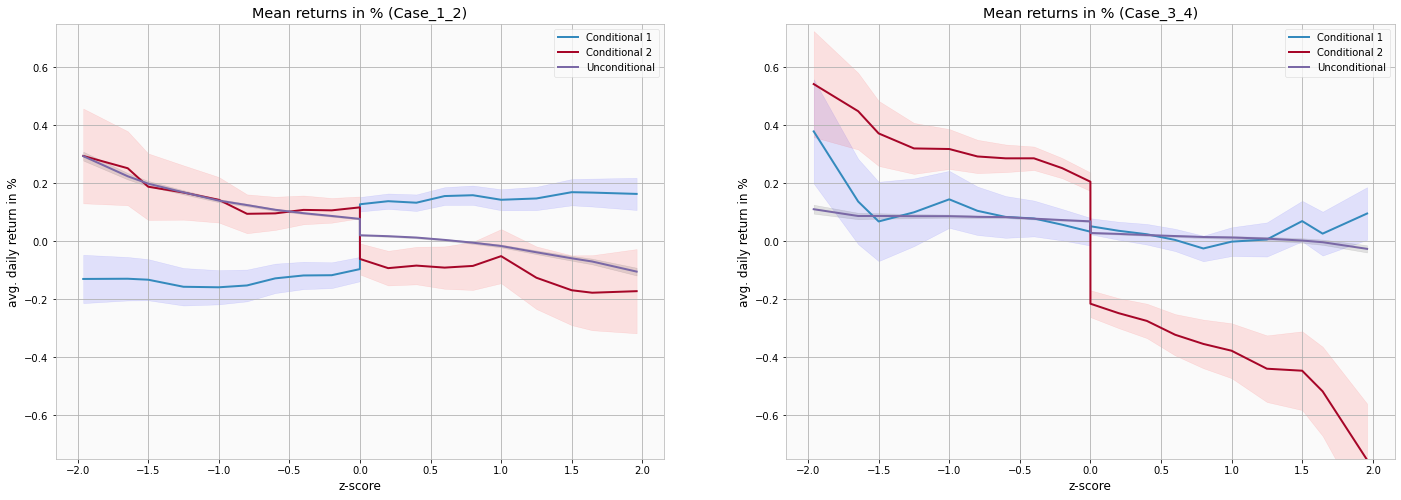

In [104]:
plot_results(table, idiosyncratic=False, show_standard_error=True) #v2.4

### 
**(b)**  
Case1&2: z-scores calculated from market **close to open**  
Case3&4: z-scores calculated from market **open to close**

In [138]:
#plot_results(table, idiosyncratic=False, show_standard_error=True)

### 
#### **1.1.2 Period 2010-2020**
**(a)**  
Case 1&2: z-scores calculated from market **open to open**  
Case 3&4: z-scores calculated from market **close to close**  

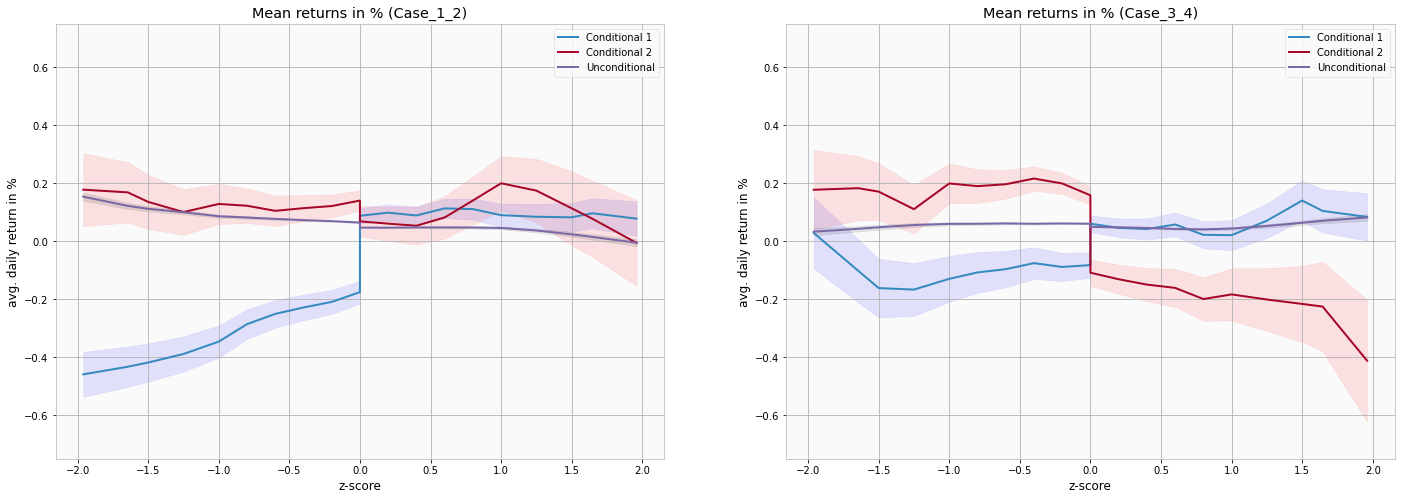

In [102]:
plot_results(table, idiosyncratic=False, show_standard_error=True) #v2.4

### 
**(b)**  
Case1&2: z-scores calculated from market **close to open**  
Case3&4: z-scores calculated from market **open to close**

In [137]:
#plot_results(table, idiosyncratic=False, show_standard_error=True)

# 
## 1.2 Idiosyncratic Returns

#### **1.2.1 Period 2002-2020**
**(a)**  
Case 1&2: z-scores calculated from market **open to open**  
Case 3&4: z-scores calculated from market **close to close**  

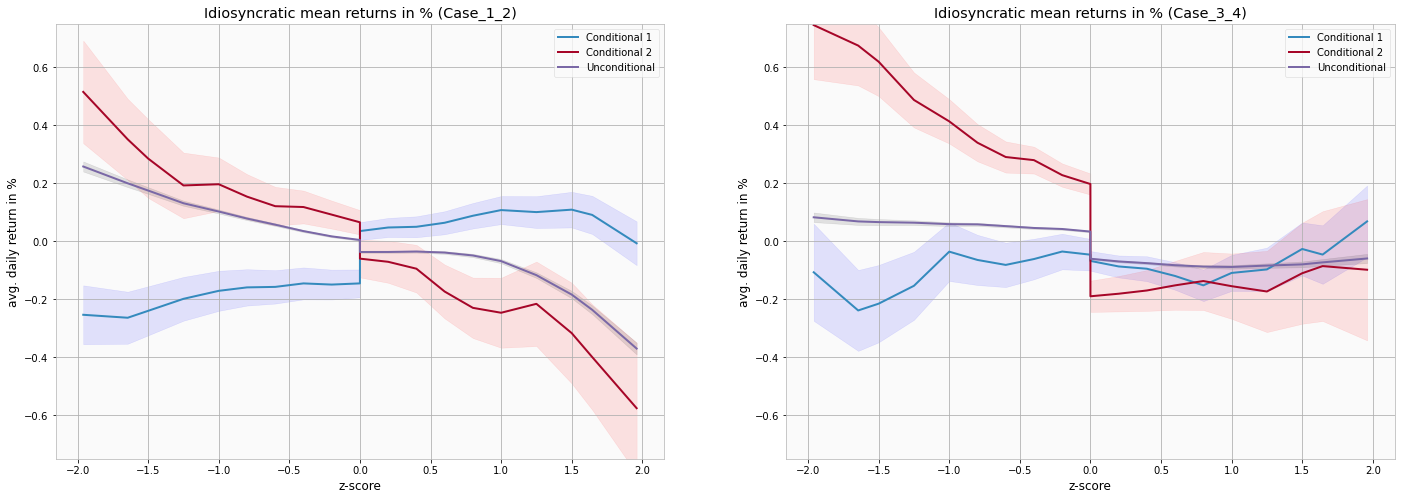

In [107]:
plot_results(table, idiosyncratic=True, show_standard_error=True) #v2.4

### 
**(b)**  
Case1&2: z-scores calculated from market **close to open**  
Case3&4: z-scores calculated from market **open to close**

In [136]:
#plot_results(table, idiosyncratic=True, show_standard_error=True)

### 
#### **1.2.2 Period 2010-2020**
**(a)**  
Case 1&2: z-scores calculated from market **open to open**  
Case 3&4: z-scores calculated from market **close to close**  

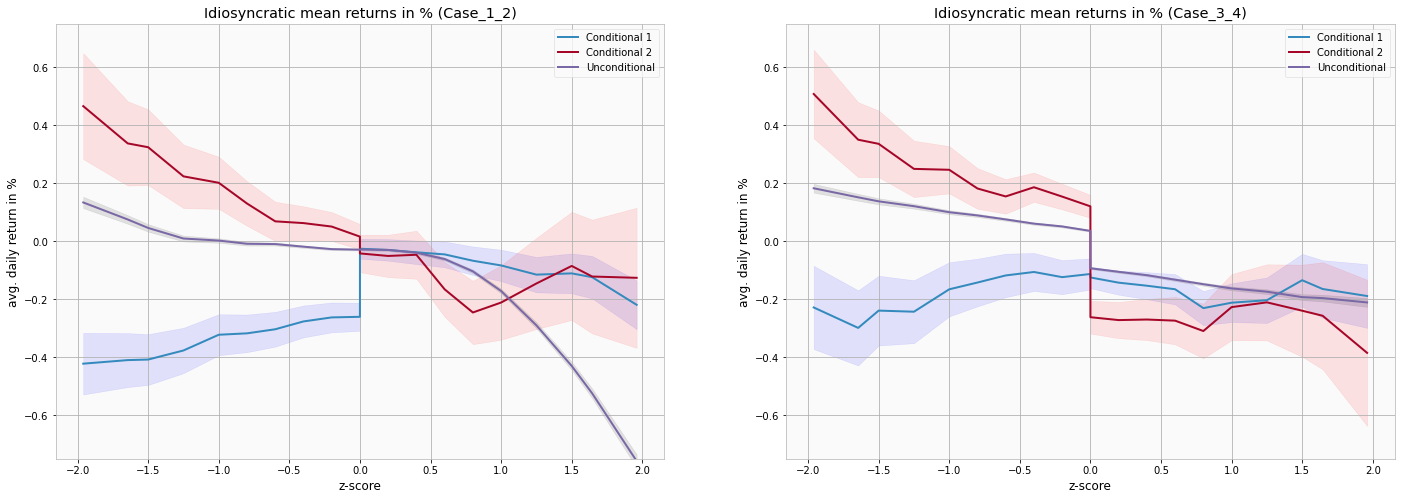

In [110]:
plot_results(table, idiosyncratic=True, show_standard_error=True) #v2.4

###
**(b)**  
Case1&2: z-scores calculated from market **close to open**  
Case3&4: z-scores calculated from market **open to close**

In [135]:
#plot_results(table, idiosyncratic=False, show_standard_error=True)

#  
## <center>---------------[ 2. Z-Scores calculated from Idiosyncratic Returns ]---------------</center>
####  

## 2.1 Total Returns
#### **2.1.1 Period 2002-2020**
**(a)**  
Case 1&2: z-scores calculated from market **open to open**  
Case 3&4: z-scores calculated from market **close to close**  

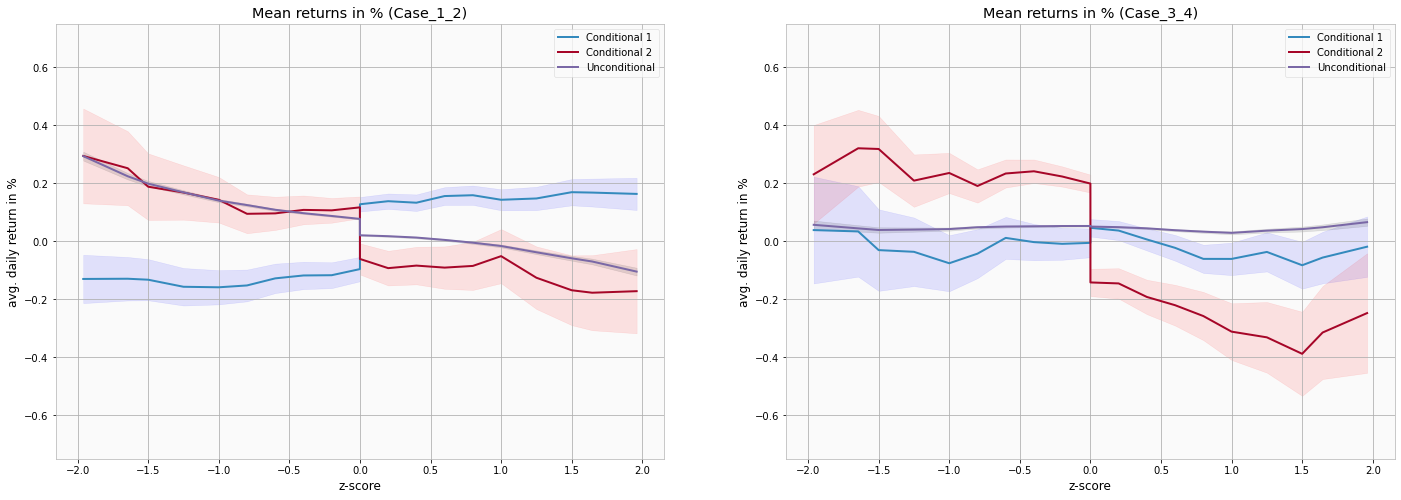

In [118]:
plot_results(table, idiosyncratic=False, show_standard_error=True) #v2.4

### 
**(b)**  
Case1&2: z-scores calculated from market **close to open**  
Case3&4: z-scores calculated from market **open to close**

In [134]:
#plot_results(table, idiosyncratic=False, show_standard_error=True) #v2.4

#### **2.1.2 Period 2010-2020**
**(a)**  
Case 1&2: z-scores calculated from market **open to open**  
Case 3&4: z-scores calculated from market **close to close**  

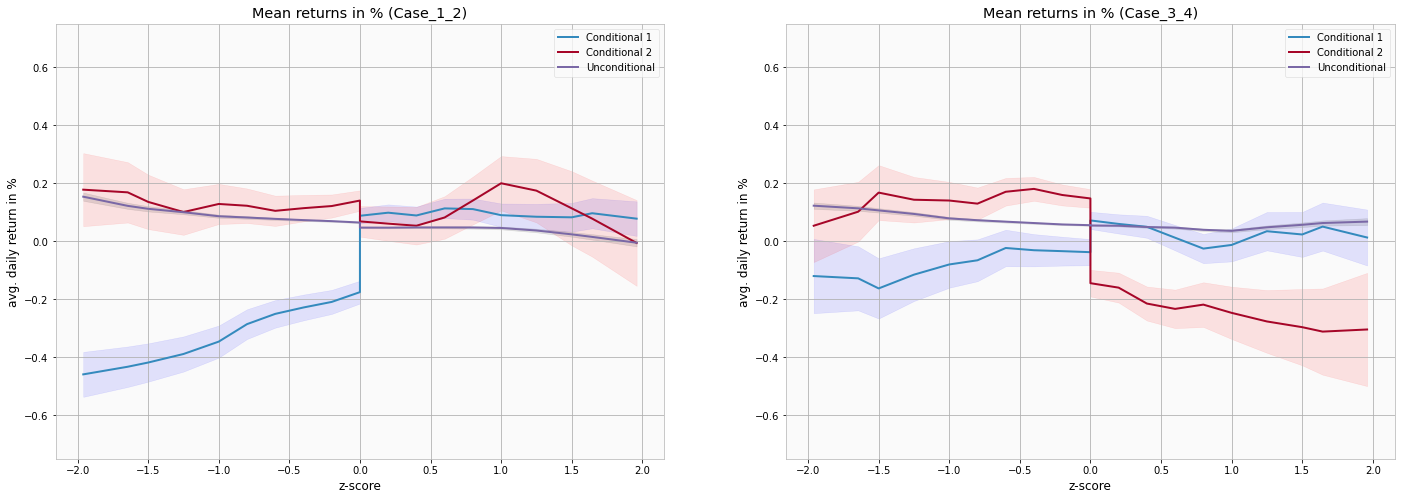

In [120]:
plot_results(table, idiosyncratic=False, show_standard_error=True) #v2.4

###
**(b)**  
Case1&2: z-scores calculated from market **close to open**  
Case3&4: z-scores calculated from market **open to close**

In [133]:
#plot_results(table, idiosyncratic=False, show_standard_error=True) #2.4

## 
## 2.2 Idiosyncratic Returns
#### **2.2.1 Period 2002-2020**
**(a)**  
Case 1&2: z-scores calculated from market **open to open**  
Case 3&4: z-scores calculated from market **close to close** 

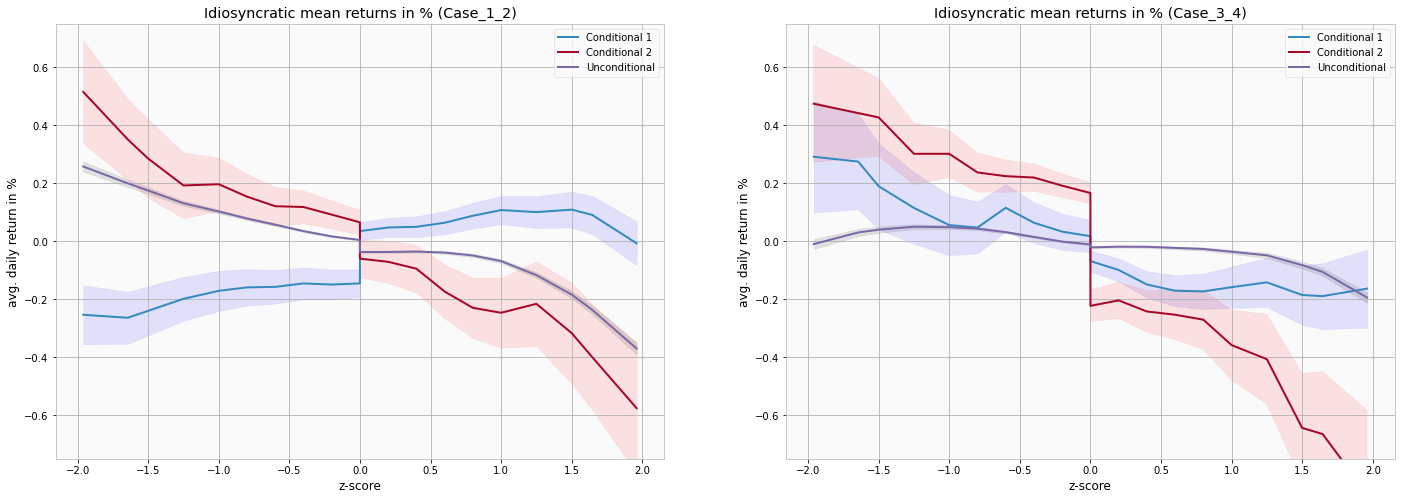

In [113]:
plot_results(table, idiosyncratic=True, show_standard_error=True) # v2.4

###
**(b)**  
Case1&2: z-scores calculated from market **close to open**  
Case3&4: z-scores calculated from market **open to close**

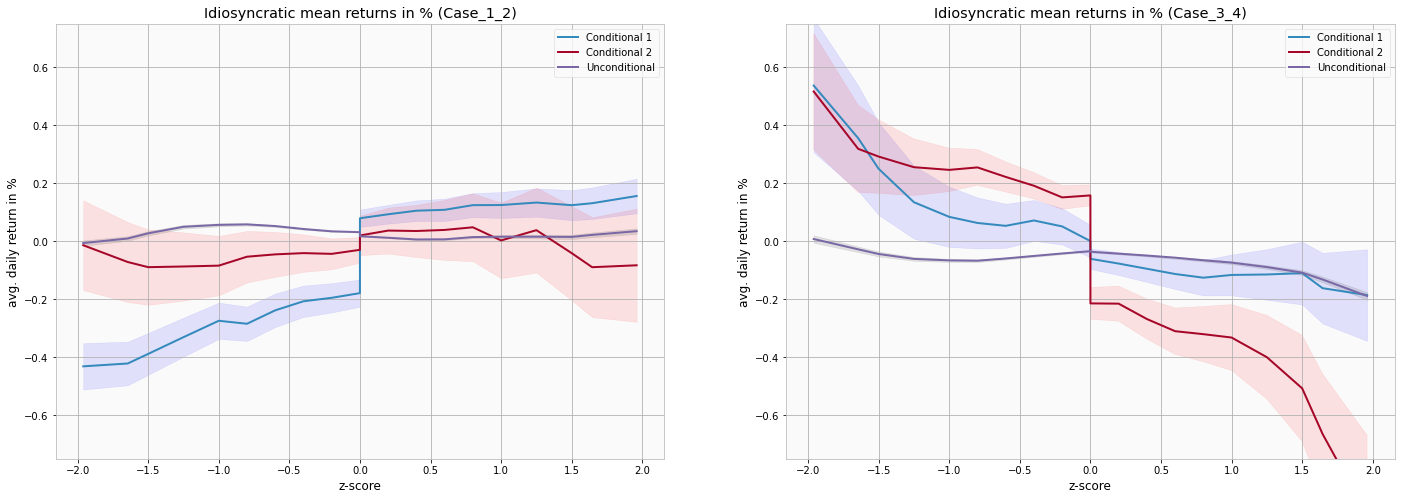

In [6]:
plot_results(table, idiosyncratic=True, show_standard_error=True) #v2.4

Return from close to open

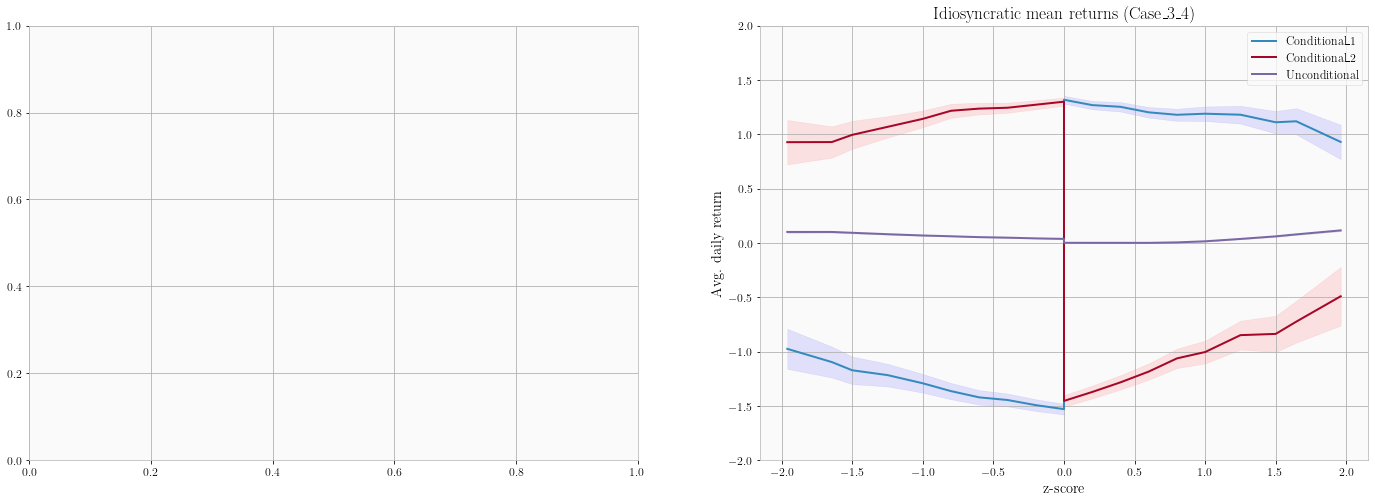

In [42]:
plot_results(table, cases=[None, 'Case_3_4'], idiosyncratic=True, show_standard_error=True, yscale=2) #v2.4

#### **2.2.2 Period 2010-2020**
**(a)**  
Case 1&2: z-scores calculated from market **open to open**  
Case 3&4: z-scores calculated from market **close to close** 

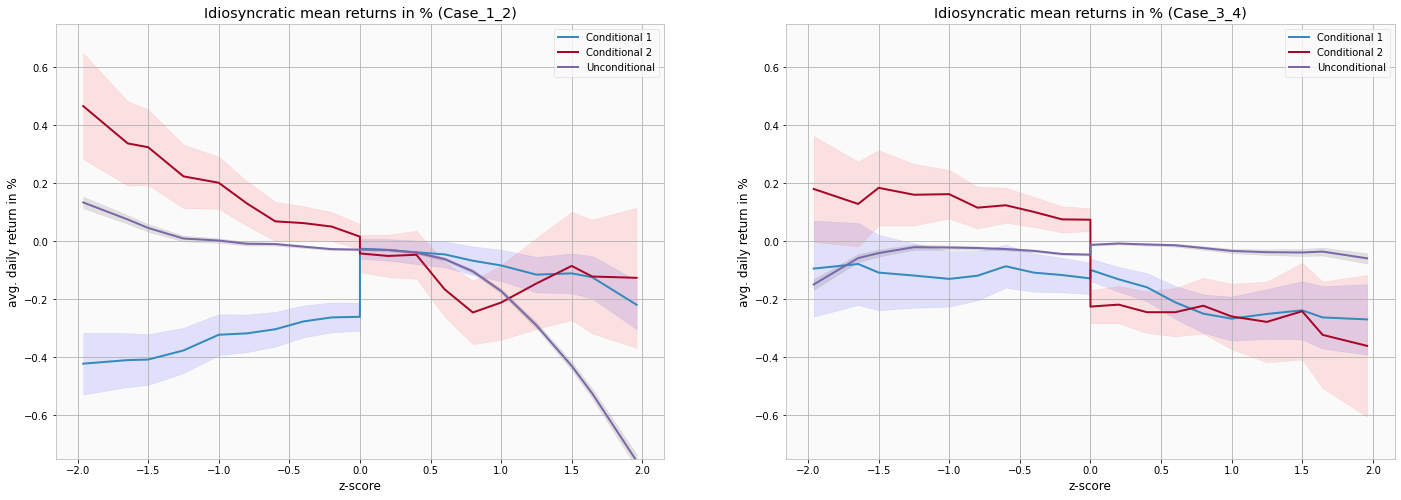

In [115]:
plot_results(table, idiosyncratic=True, show_standard_error=True) # v2.4

### 
**(b)**  
Case1&2: z-scores calculated from market **close to open**  
Case3&4: z-scores calculated from market **open to close**

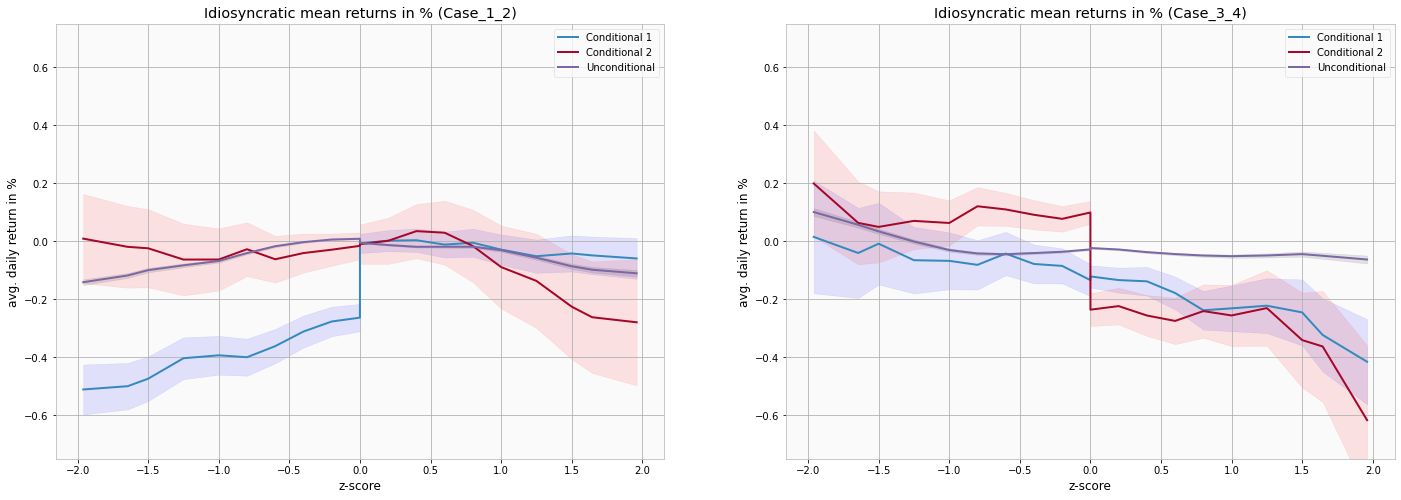

In [150]:
plot_results(table, idiosyncratic=True, show_standard_error=True) #v2.4

Caption:  


Return from close to open

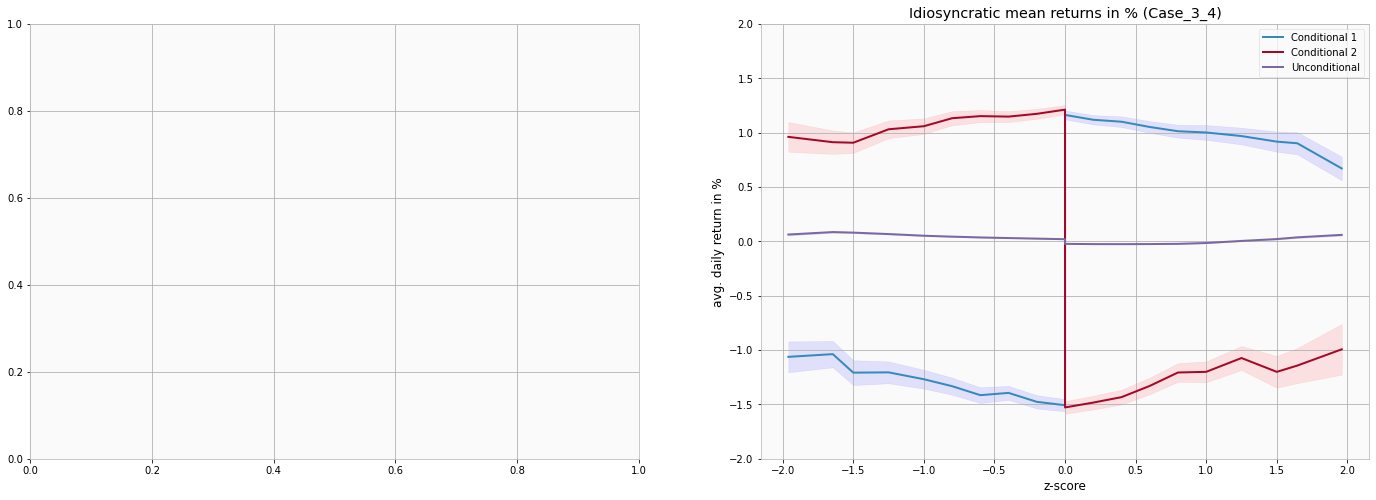

In [328]:
plot_results(table, cases=[None, 'Case_3_4'], idiosyncratic=True, show_standard_error=True, yscale=2) #v2.4

Caption:  

News with positive (negative) predicted sentiment are associated with positive (negative) returns in the same period. More precisely, we consider financial news published during market closing hours from 4pm on day t-1 to 9:30am on day t. Also, we report equity returns of companies associated with those news, measured from market close (t-1) to market open (t), relative to the z-score measured at market close. This plot clearly shows the positive correlation between predicted news sentiment and realized returns, which proves the ability of our model to correctly identify the sentiment of news articles. Furthermore, it can be seen that 

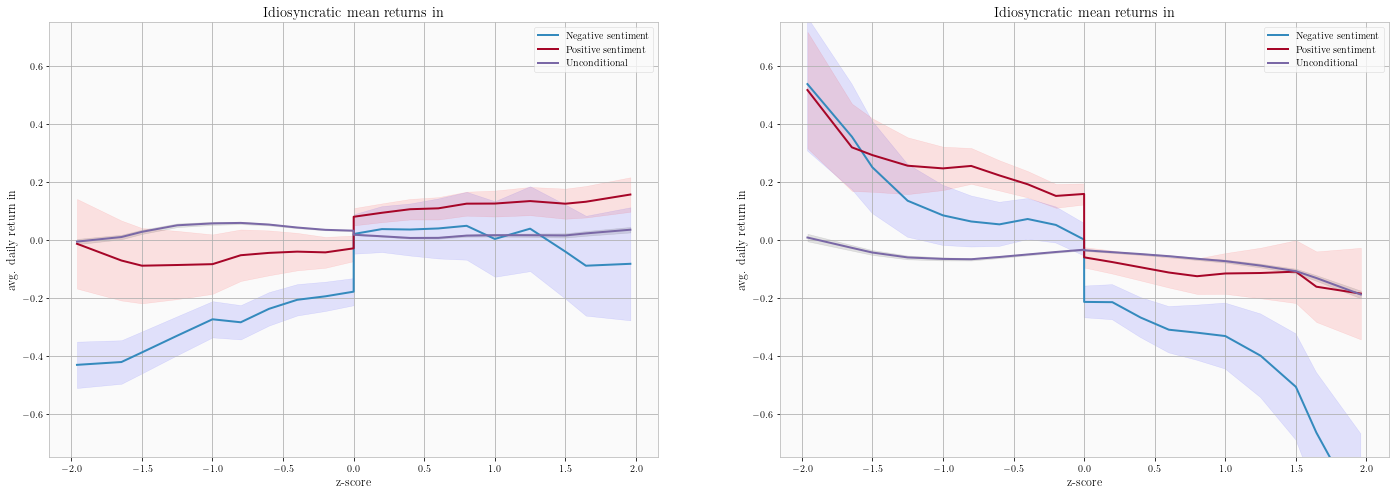

In [9]:
plot_results(table, cases=['Case_1_2', 'Case_3_4'], idiosyncratic=True, show_standard_error=True,  display_style='sentiment') 

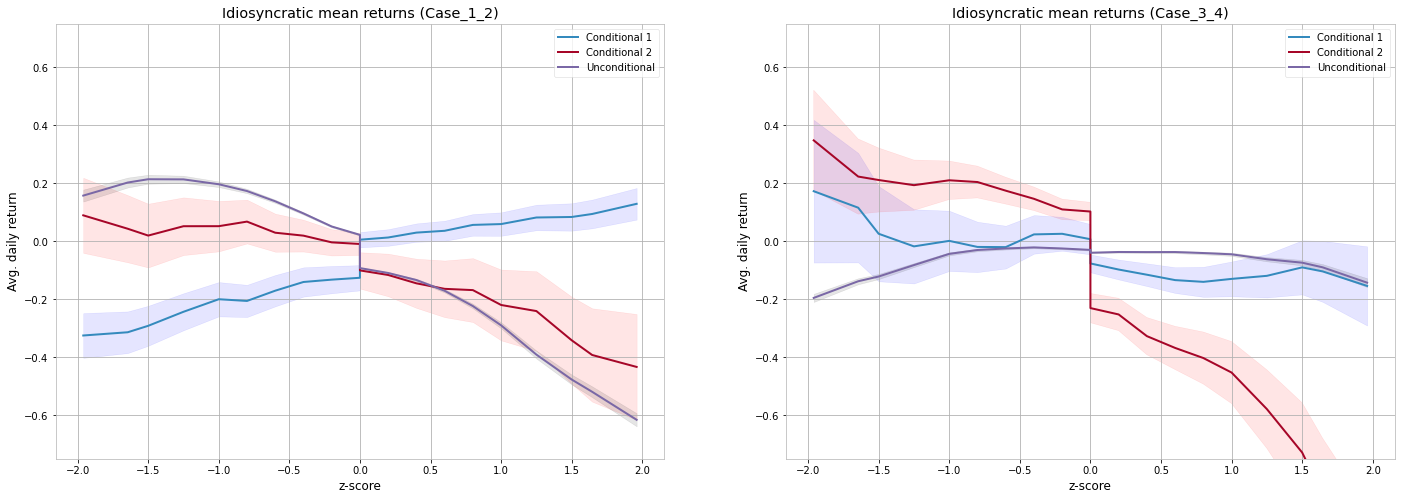

In [48]:
plot_results(table, idiosyncratic=True, show_standard_error=True) #v2.4 mo_to_mc, 2002-2020

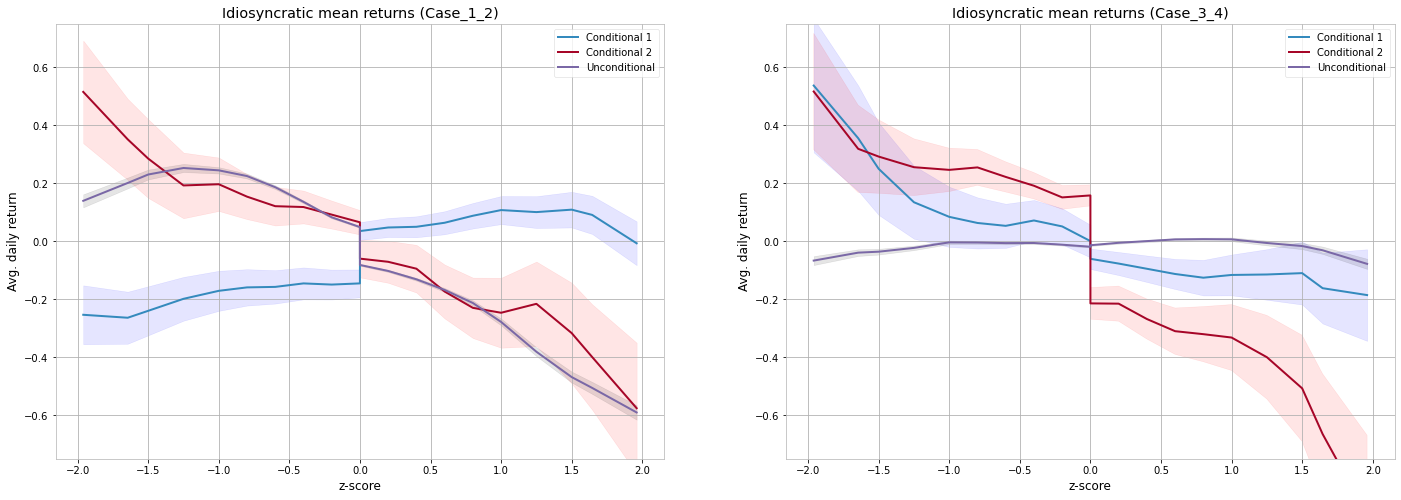

In [37]:
plot_results(table, idiosyncratic=True, show_standard_error=True) #v2.4 mo_to_mo, 2002-2020

Fresh News (idiosyncratic returns, idiosyncratic z-scores, period 2002-2020) 

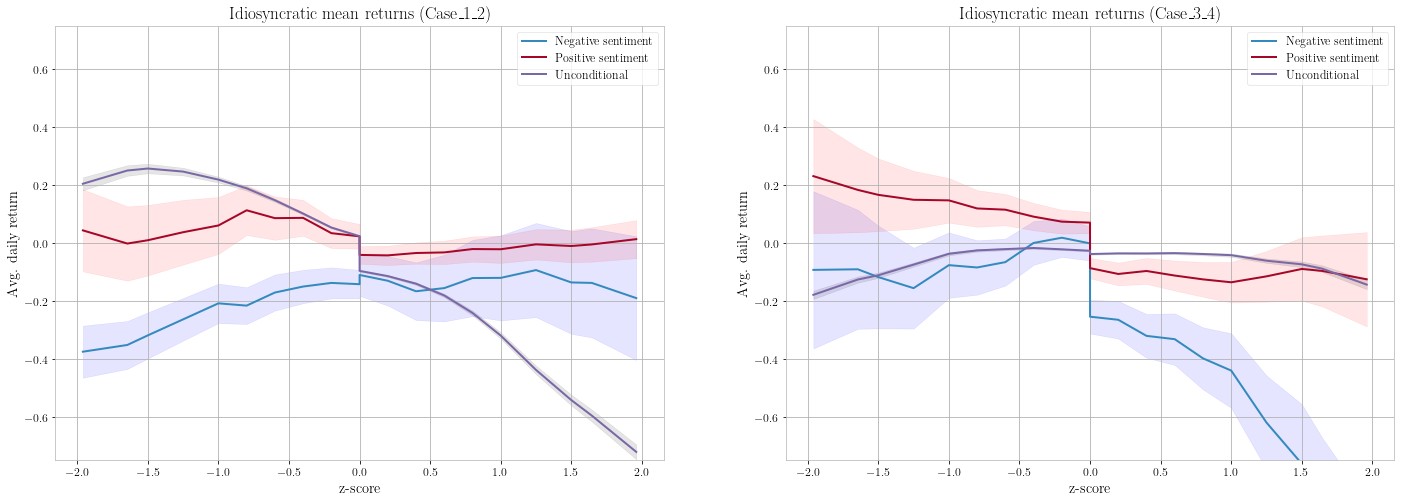

In [132]:
plot_results(table, idiosyncratic=True, show_standard_error=True, display_style='sentiment') #v2.4 

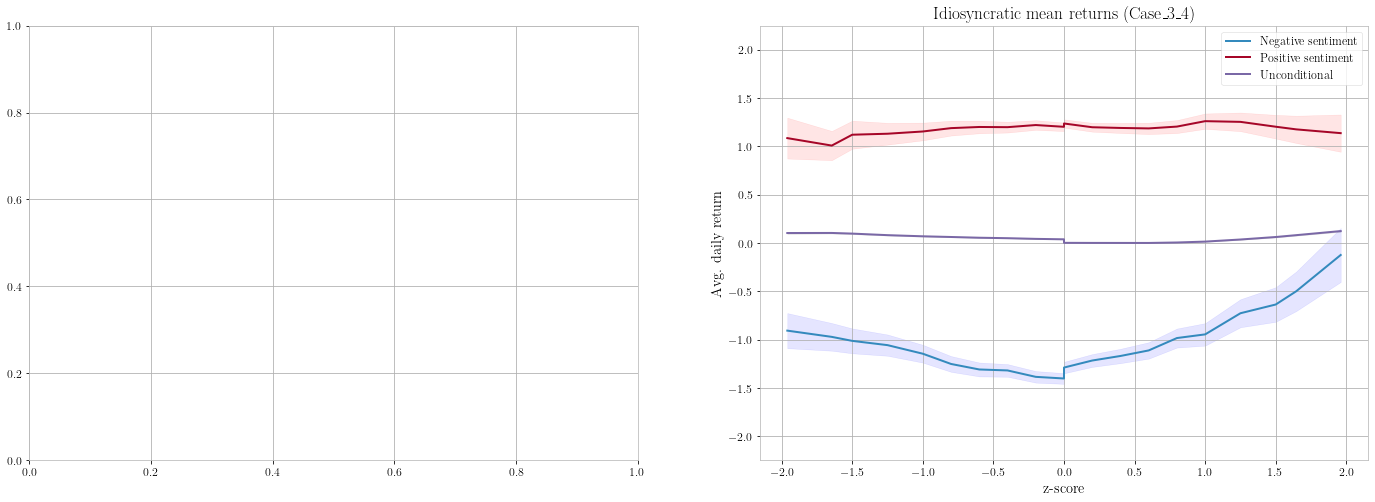

In [142]:
plot_results(table, cases=[None, 'Case_3_4'], idiosyncratic=True, show_standard_error=True, yscale=2.25, display_style='sentiment') #v2.4 

Stale News (idiosyncratic returns, idiosyncratic z-scores, period 2002-2020) 

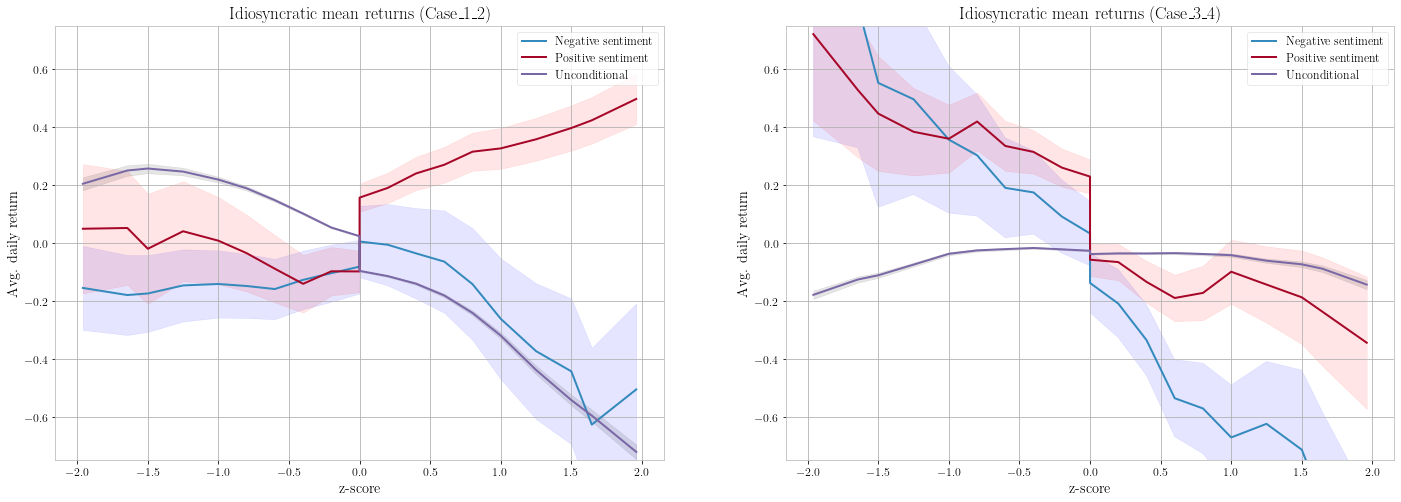

In [116]:
plot_results(table, idiosyncratic=True, show_standard_error=True, display_style='sentiment') #v2.4 #exlusive unconditional

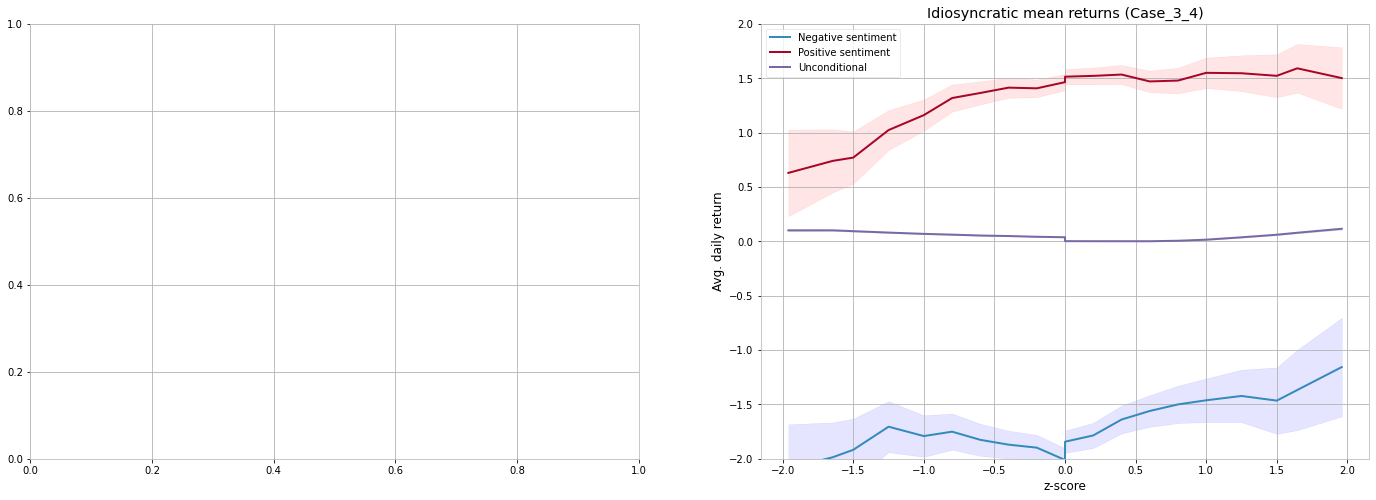

In [87]:
plot_results(table, cases=[None, 'Case_3_4'], idiosyncratic=True, show_standard_error=True, yscale=2.25, display_style='sentiment') #v2.4 

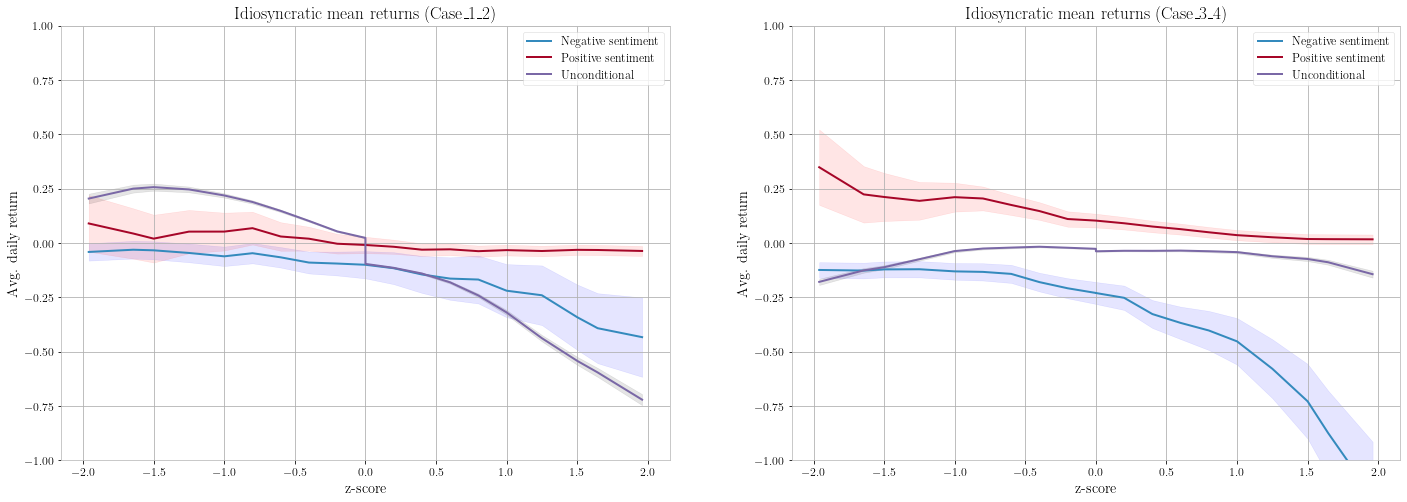

In [28]:
plot_results(table, idiosyncratic=True, show_standard_error=True, yscale=1)

Export plots for documentation

In [11]:
def export_plot(table, 
                case='Case_1_2', 
                idiosyncratic=False, 
                show_standard_error=True, 
                yscale=0.75,
                export=False, 
                title=None,
                xlabel=None,
                ylabel=None,
                filename=datetime.now().strftime("%m%d%Y_%Hh%Mm%Ss")):    
    
    save_path = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/ShortTerm Momentum/plots/"
    
    fontsize = 12
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': fontsize})
    rc('text', usetex=True)

    # linestyles
    col  = ["#348ABD", "#A60628", "#7A68A6"]
    line = ["dashed", "dashdot", "solid"]

    axes  = {}
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    
    mean_0       = table['Unconditional'].loc[('mean', case)]*100
    std_error_0  = table['Unconditional'].loc[('std_error', case)]*100

    mean_1, label_1 = cal_metric(case, metric='mean',      setting='neg_sentiment')
    mean_2, label_2 = cal_metric(case, metric='mean',      setting='pos_sentiment')               
    std_error_1, _  = cal_metric(case, metric='std_error', setting='neg_sentiment')
    std_error_2, _  = cal_metric(case, metric='std_error', setting='pos_sentiment')
    
    above_line_0 = (mean_0.values+std_error_0.values).astype(np.float32)
    below_line_0 = (mean_0.values-std_error_0.values).astype(np.float32)
    above_line_1 = (mean_1.values+std_error_1.values).astype(np.float32)
    below_line_1 = (mean_1.values-std_error_1.values).astype(np.float32)
    above_line_2 = (mean_2.values+std_error_2.values).astype(np.float32)
    below_line_2 = (mean_2.values-std_error_2.values).astype(np.float32)


    ax.plot(mean_1, label=label_1, linestyle='dashed', linewidth=1.5, color=col[0])
    ax.plot(mean_2, label=label_2, linestyle='dashdot', linewidth=1.5, color=col[1])
    ax.plot(mean_0, label='Without news events', linewidth=1.5, color=col[2])
    if show_standard_error:
        ax.fill_between(mean_1.index, above_line_1, below_line_1, color='b', alpha=.1) 
        ax.fill_between(mean_2.index, above_line_2, below_line_2, color='r', alpha=.1) 
        ax.fill_between(mean_0.index, above_line_0, below_line_0, color='k', alpha=.1) 

    ax.set_xlabel('z-score', labelpad=15)
    #ax.set_ylabel('Avg. daily return (in %)')
    ax.set_ylim([-yscale,yscale])
    ax.set_xlim([-2,2])
    ax.legend()
    if title != None:
        ax.set_title(title)
    if xlabel != None:
        ax.set_xlabel(xlabel)
    if ylabel != None:
        ax.set_ylabel(ylabel)
    if export:
        plt.savefig(save_path+filename+'_'+datetime.now().strftime("%Hh%Mm%Ss")+'.pdf', bbox_inches='tight')
    plt.show()

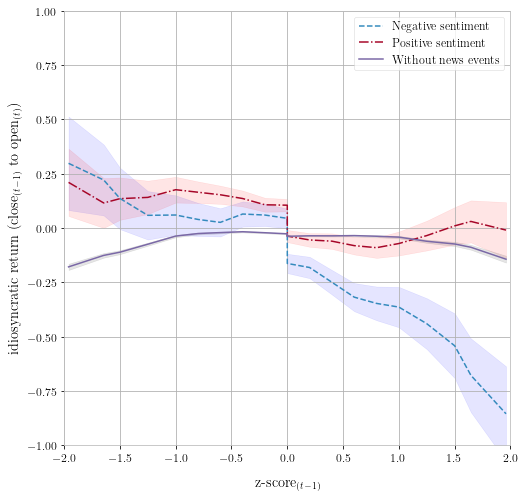

In [12]:
export_plot(table, 
            case ='Case_3_4', 
            idiosyncratic=True, 
            show_standard_error=True, 
            yscale=1,
            export   = False, 
            title    = None, #'Fresh News',
            xlabel   = 'z-score$_{(t-1)}$',        
            ylabel   = 'idiosyncratic return (close$_{(t-1)}$ to open$_{(t)}$)',           # (open$_{(t)}$ to close$_{(t)}$), (close$_{(t-1)}$ to open$_{(t)}$), (open$_{(t)}$ to open$_{(t+1)}$)
            filename = "idiosync_return_mc_to_mo__z_mo_to_mc_idiosync_case34_2002_2020_excl_cond_vix_below_20") 


# idiosync_return_mo_to_mo__z_mo_to_mc_idiosync_case34_2002_2020
# idiosync_return_mc_to_mo__z_mo_to_mc_idiosync_case34_2002_2020

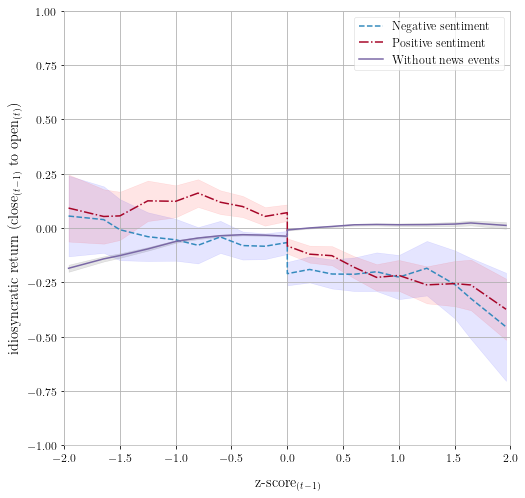

In [11]:
export_plot(table, 
            case ='Case_3_4', 
            idiosyncratic=True, 
            show_standard_error=True, 
            yscale=1,
            export   = False, 
            title    = None, #'Fresh News',
            xlabel   = 'z-score$_{(t-1)}$',        
            ylabel   = 'idiosyncratic return (close$_{(t-1)}$ to open$_{(t)}$)',           # (open$_{(t)}$ to close$_{(t)}$), (close$_{(t-1)}$ to open$_{(t)}$), (open$_{(t)}$ to open$_{(t+1)}$)
            filename = "idiosync_return_mc_to_mo__z_mo_to_mc_idiosync_case34_2002_2020_excl_cond_vix_below_20") 


# idiosync_return_mo_to_mo__z_mo_to_mc_idiosync_case34_2002_2020
# idiosync_return_mc_to_mo__z_mo_to_mc_idiosync_case34_2002_2020

Return Distribution

In [112]:
table = S.calc_stats(settings     = ['Conditional_2'], 
                     return_period= 'mo_to_mo',           # 'mo_to_mo' or 'mc_to_mo'
                     period_start = datetime(2002,1,1), 
                     period_end   = datetime(2019,12,31),
                     z_scores = [1.645])                                    

Conditional_2


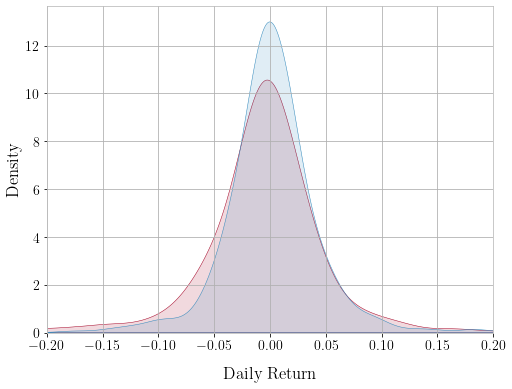

In [129]:
export = False
filename = "r_dist_Conditional_2_mo_to_mo_z_1_645_2002-2020"

fontsize = 14
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': fontsize})
rc('text', usetex=True)

save_path = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/ShortTerm Momentum/plots/"

fix, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(data=S.strategy_df[['Case_3', 'Case_4']], common_norm=False, fill=True, cumulative=False, legend=False, bw_adjust=1, gridsize=1000, alpha=0.15)
plt.xlim(-0.2, 0.2)
#plt.legend(loc='upper right', labels=['Pos. sentiment, z-value $<=$ -1.645', 'Neg. sentiment, z-value $>=$ 1.645'])
plt.xlabel('Daily Return', labelpad=15)
if export:
     plt.savefig(save_path+filename+'_'+datetime.now().strftime("%Hh%Mm%Ss")+'.pdf', dpi=100, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()